<a href="https://colab.research.google.com/github/pulinduvidmal/Deep-Learning-with-PyTorch-Object-Localization/blob/main/Copy_of_Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

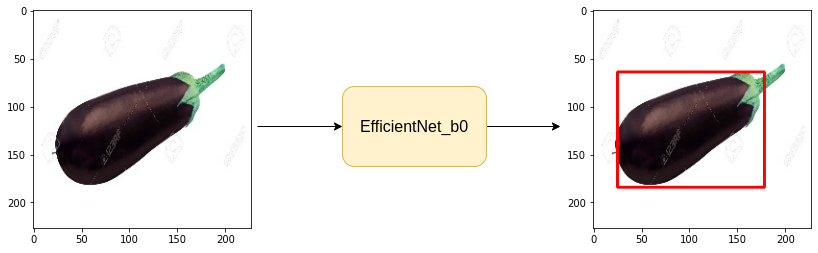

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm  #libries
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-laplrr95
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-laplrr95
  Resolved https://github.com/albumentations-team/albumentations to commit 004fabbf90794fbc21ee356e2dde6637b7fecbd4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
csv_file="/content/object-localization-dataset/train.csv"
data_dir = "/content/object-localization-dataset/"

DEVICE ='cuda'

batch_size=16
img_size = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME ='efficientnet b0 '

NUM_COR =4

In [ ]:
df=pd.read_csv(csv_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

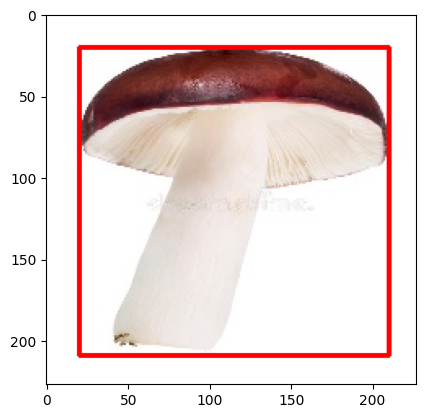

In [ ]:
row =df.iloc[111]
img = cv2.imread(data_dir + row.img_path)
# img=cv2.cvtColor(img, cv2.COLOR BGR2RGB) eroor fri=om split concept
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin,row.ymin)
pt2 = (row.xmax,row.ymax)

#plt.imshow(img)

bnd_box_IMG = cv2.rectangle(img,pt1,pt2,(255,0,0),2) #line size = 2


plt.imshow(bnd_box_IMG)

In [ ]:
train_df,valid_df=train_test_split(df,test_size =0.2 , random_state =42)

# Augmentations

In [ ]:
import albumentations as A #very important libary for augmentations
#use for loa=calization or detection

In [ ]:
"""
#training augmentations
train_augs = A.Compose([
    A.Resize(img_size,img_size),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate()


],bbox_params=A.BboxParams(format = 'pascal_voc',label_fields=['class_Lables']))



#validartion augmentations
valid_augs = A.Compose([
    A.Resize(img_size,img_size),



],bbox_params=A.BboxParams(format = 'pascal_voc',label_fields=['class_Lables']))"""

"\n#training augmentations\ntrain_augs = A.Compose([\n    A.Resize(img_size,img_size),\n    A.VerticalFlip(p=0.5),\n    A.HorizontalFlip(p=0.5),\n    A.Rotate()\n\n  \n],bbox_params=A.BboxParams(format = 'pascal_voc',label_fields=['class_Lables']))\n\n\n\n#validartion augmentations\nvalid_augs = A.Compose([\n    A.Resize(img_size,img_size),\n    \n\n  \n],bbox_params=A.BboxParams(format = 'pascal_voc',label_fields=['class_Lables']))"

In [ ]:
train_augs=A.Compose([
    A.Resize(img_size,img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(),
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))
val_augs=A.Compose([
    A.Resize(img_size,img_size),
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))


# Create Custom Dataset

In [ ]:
"""class ObjLocDataset(torch.utils.data.Dataset):
  def init(self,df,augmentations=None):
    self.df=df
    self.augmentations = augmentations

    def __len__(self):
      return  len(self.df)

    def getitem (self,idx):
      row = self.df.iloc[idx]
      xmin = row.xmin
      ymin = row.ymin

      Xmax = row.Xmax
      Ymax = row.Ymax

      bbox =[[xmin,ymin,Xmax,Ymax]]

      img_path=data_dir + row.img_path
      img=cv2.imread(img_path)
      img  = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

      if self.augmentations:
        data= self.augmentations(image=img,bboxes  =bbox, class_labels=[None]) #since no classificaition we take lables = None
        img = data['image']
        bbox = data['bboxes'][0] #for get index


      img = torch.from_numpy(img).permute(2,0,1)/255.0
      bbox=torch.Tensor(bbox)

      return img,bbox
"""


"class ObjLocDataset(torch.utils.data.Dataset):\n  def init(self,df,augmentations=None):\n    self.df=df\n    self.augmentations = augmentations\n\n    def __len__(self):\n      return  len(self.df)\n\n    def getitem (self,idx):\n      row = self.df.iloc[idx]\n      xmin = row.xmin\n      ymin = row.ymin\n\n      Xmax = row.Xmax\n      Ymax = row.Ymax\n\n      bbox =[[xmin,ymin,Xmax,Ymax]]\n\n      img_path=data_dir + row.img_path\n      img=cv2.imread(img_path)\n      img  = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)\n\n      if self.augmentations:\n        data= self.augmentations(image=img,bboxes  =bbox, class_labels=[None]) #since no classificaition we take lables = None\n        img = data['image']\n        bbox = data['bboxes'][0] #for get index\n\n\n      img = torch.from_numpy(img).permute(2,0,1)/255.0\n      bbox=torch.Tensor(bbox)\n\n      return img,bbox\n"

In [ ]:

class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        """
        Initialize the Object Localization Dataset.

        Args:
            df (DataFrame): DataFrame containing image paths and bounding box coordinates.
            augmentations (albumentations.Compose, optional): Augmentation pipeline to be applied to images and bounding boxes.
        """
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Gets an item (image and bounding box) from the dataset by index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: Tuple containing the image tensor and bounding box tensor.
        """
        row = self.df.iloc[idx]
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax  # Corrected variable name 'Xmax' to 'xmax'
        ymax = row.ymax  # Corrected variable name 'Ymax' to 'ymax'

        bbox = [[xmin, ymin, xmax, ymax]]

        img_path = data_dir + row.img_path  # Assuming data_dir is defined elsewhere
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])  # Assuming no classification labels
            img = data['image']
            bbox = data['bboxes'][0]  # Assuming only one bounding box per image

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
        bbox = torch.Tensor(bbox)

        return img, bbox


In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, val_augs)


In [ ]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")

Total examples in the trainset : 148
Total examples in the validset : 38


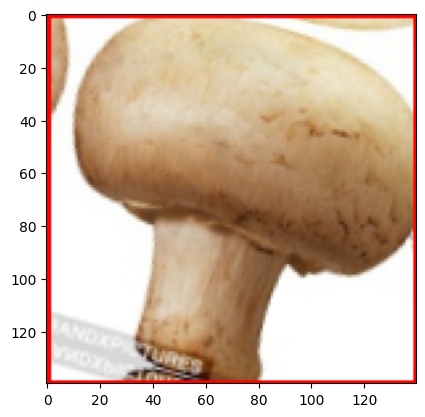

In [ ]:
img, bbox = trainset[15]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images,bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm #pretarin

In [ ]:
class OLModel(nn.Module):
  def __init__(self):
    super(OLModel,self).__init__()
    self.backbone = timm.create_model('efficientnet_b0',pretrained= True, num_classes = 4)

  def forward(self,images,gt_bboxes = None):
    bboxes = self.backbone(images)


    if gt_bboxes!= None:
      loss=nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes,loss
    return bboxes







In [ ]:
model = OLModel()
#model.to(DEVICE)

In [ ]:
random_img = torch.rand(1,3,140,140) #.to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model,dataloader,optimizer):
  total_loss =0.0
  model.train()  #Dropout ON

  for data in tqdm(dataloader):
    images,gt_boxes = data
   # images,gt_bboxes=images.to(DEVICE),gt_bboxes.to(DEVICE)
    #images,gt_bboxes=images,gt_bboxes

    bboxes,loss=model(images, gt_boxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(dataloader)





In [ ]:

def eval_fn(model,dataloader):
  total_loss=0.0
  model.eval()#Dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,gt_bboxes=data
      images,gt_bboxes=images,gt_bboxes
     # images,gt_bboxes=images.to(DEVICE),gt_bboxes.to(DEVICE)

      bboxes,loss=model(images, gt_bboxes)

      total_loss+=loss.item()

    return total_loss/len(dataloader)

#Training Loop

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
import numpy as np

best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:

        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHTS ARE SAVED")
        best_valid_loss = valid_loss
    print(f"epoch:{i+1}, train_loss:{train_loss}, val_loss:{valid_loss}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
epoch:1, train_loss:1865.0412475585938, val_loss:747.6220499674479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
epoch:2, train_loss:982.2978881835937, val_loss:594.7216186523438


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
epoch:3, train_loss:656.1545837402343, val_loss:252.40583292643228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
epoch:4, train_loss:407.2416564941406, val_loss:203.33514404296875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
epoch:5, train_loss:297.66900634765625, val_loss:154.84999084472656


  0%|          | 0/10 [00:00<?, ?it/s]

#Inference

In [ ]:
import utils

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox=valset[12]#ch,h,w
  image=image.unsqueeze(0).to(DEVICE)#batch,ch,h,w
  out_bbox=model(image)

  utils.compare_plots(image,gt_bbox,out_bbox)#green->ground truth bounding box(gt_bbox),red->out_bbox



# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya